In [1]:
import MDAnalysis as mda
from numpy import *
import os
from pylab import *
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import glob
#import umap
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
import mdtraj
import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [2]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=sorted(glob.glob(h2opath+"*.gro"))
peggros=sorted(glob.glob(pegpath+"*.gro"))

#glob tprs
h2otprs=sorted(glob.glob(h2opath+"*.tpr"))
pegtprs=sorted(glob.glob(pegpath+"*.tpr"))

#trjs
h2otrjs=sorted(glob.glob(h2opath+"*.xtc"))
pegtrjs=sorted(glob.glob(pegpath+"*.xtc"))

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))#get universes 
#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2otprs[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(pegtprs[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper

#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#0A732D","#332288"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]



In [3]:
def getRMSF(systems,datasets,selection_strings,EQPOINT=250):
    allrmsfs=[]
    rmsfs=[]
    stderrs=[]
    for i in range(len(datasets)):
        subrmsfs = []
        for j in range(len(datasets[i])):
            
            prealigner = align.AlignTraj(systems[i][j],systems[i][j], select=selection_strings[i][j], in_memory=True).run()
            reference_coordinates = systems[i][j].trajectory.timeseries(asel=datasets[i][j]).mean(axis=1)
            reference = mda.Merge(datasets[i][j]).load_new(reference_coordinates[:, None, :], order="afc")
            aligner = align.AlignTraj(systems[i][j], reference, select=selection_strings[i][j], in_memory=True).run()
            
            R = MDAnalysis.analysis.rms.RMSF(datasets[i][j])
            R.run(start=EQPOINT)
            
            subrmsfs.append(R.rmsf)
        allrmsfs.append(subrmsfs)
        #rmsfs.append(mean(subrmsfs,axis = 0))
        #stderrs.append(scipy.stats.sem(subrmsfs,axis = 0))


    return allrmsfs#rmsfs,stderrs

#def GetResSlices(topology,trajectory):
#    u = mda.Universe(topology,trajectory)
#    protein = u.select_atoms("protein and not name H*")
#    resslices=[0]
#    t=0
#    for i in range(len(protein.residues)):
#        t+=len(protein.residues[i].atoms.select_atoms("not name H*"))
#        resslices.append(t)
#    return resslices
def GetResSlicesU(sel):
    protein = sel
    resslices=[0]
    t=0
    for i in range(len(protein.residues)):
        t+=len(protein.residues[i].atoms)
        resslices.append(t)
    return resslices
def atoms_to_residues(datalist,res_slice_list):
    
    newdatalist=[]
    for j in range(len(datalist)):
        newdata=[]
        for i in range(len(res_slice_list[j])-1):
            newdata.append(mean(datalist[j][res_slice_list[j][i]:res_slice_list[j][i+1]]))
        newdatalist.append(newdata)
    return newdatalist


res_slices=[]
for i in range(len(systems)):
    res_slices.append(GetResSlicesU(fullprotein_selections[i][0]))
    
    
allrmsfs=getRMSF(systems,fullprotein_selections,fullprotein_selections_string,EQPOINT=EQPOINT)



/home/liam/.local/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:885: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [19]:
allrmsfs_residue=[]


for i in range(len(allrmsfs)):
    allrmsfs_system=[]
    for j in range(len(allrmsfs[i])):
        allrmsfs_trj=[]
        for k in range(len(res_slices[i])-1):
            allrmsfs_trj.append(mean(allrmsfs[i][j][res_slices[i][k]:res_slices[i][k+1]]))
        allrmsfs_system.append(allrmsfs_trj)
    allrmsfs_residue.append(allrmsfs_system)
            
system_rmsf = []
sem_rmsf = []
for i in range(len(allrmsfs_residue)):
    system_rmsf.append(mean(allrmsfs_residue[i],axis = 0))
    sem_rmsf.append(scipy.stats.sem(allrmsfs_residue[i],axis = 0))
    
    
system_rmsf_withnans=[]
sem_rmsf_withnans=[]
for i in range(len(system_rmsf)):
    
    test=system_rmsf[i]
    test_sem=sem_rmsf[i]
    test_put_in_nans=[]
    test_sem_put_in_nans=[]
    for j in range(70):
        test_put_in_nans.append(test[j])
        test_sem_put_in_nans.append(test_sem[j])
    test_put_in_nans.append(nan)
    test_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    for j in range(70,len(test)):
        test_put_in_nans.append(test[j])    
        test_sem_put_in_nans.append(test_sem[j])    
    system_rmsf_withnans.append(array(test_put_in_nans)) 
    sem_rmsf_withnans.append(array(test_sem_put_in_nans))

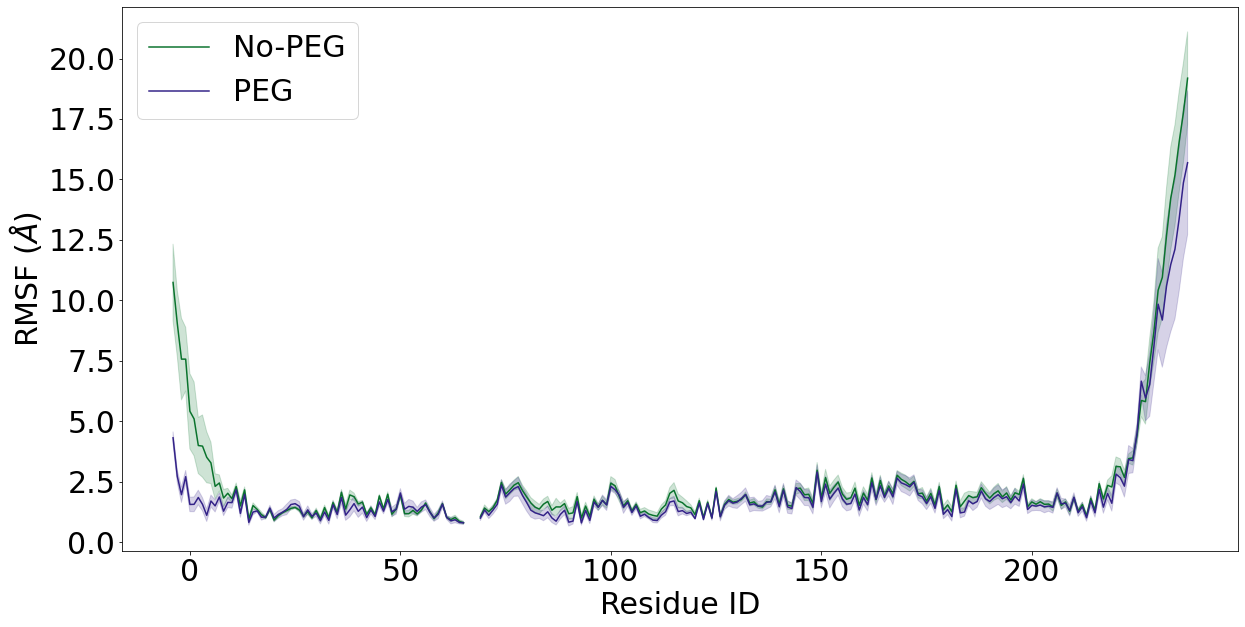

In [22]:
#style.use("seaborn-poster")
figure(figsize = (20,10))
for i in range(len(systems)):
    plot(resids,system_rmsf_withnans[i],color = colourScheme[i],label = system_names[i])
    fill_between(resids,system_rmsf_withnans[i] - sem_rmsf_withnans[i], system_rmsf_withnans[i] + sem_rmsf_withnans[i],color = colourScheme[i],alpha = 0.2)


legend(fontsize = 30)

xlabel("Residue ID",fontsize = 30)
ylabel("RMSF ($\AA$)",fontsize = 30)
adsfvadsfvasd=xticks(fontsize = 30)
vfdavfdasfvsd=yticks(fontsize = 30)

In [23]:
save("system_rmsf_withnans.npy",system_rmsf_withnans)
save("sem_rmsf_withnans.npy",sem_rmsf_withnans)